In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 24.1 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import torch
import numpy as np

from nltk.tokenize import sent_tokenize

from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.bpe import BPETokenizer
from mingpt.utils import set_seed
set_seed(1234)

In [ ]:
import pandas as pd

In [ ]:
import datasets
sst = datasets.load_dataset('glue', 'sst2')

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
print(sst['train'][:1200])

{'sentence': ['hide new secretions from the parental units ', 'contains no wit , only labored gags ', 'that loves its characters and communicates something rather beautiful about human nature ', 'remains utterly satisfied to remain the same throughout ', 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ', "that 's far too tragic to merit such superficial treatment ", 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ', 'of saucy ', "a depressed fifteen-year-old 's suicidal poetry ", "are more deeply thought through than in most ` right-thinking ' films ", 'goes to absurd lengths ', "for those moviegoers who complain that ` they do n't make movies like they used to anymore ", "the part where nothing 's happening , ", 'saw how bad this movie was ', 'lend some dignity to a dumb story ', 'the greatest musicians ', 'cold movie ', 'with his usual intelligence and subtl

In [ ]:
class sentimentDataset(Dataset):

    def __init__(self, split="train", truncation=-1):


        self.truncation = truncation  # int. If -1, then

        sst = datasets.load_dataset('glue', 'sst2')
        trainSplit = sst['train'][:1200]
        df = pd.DataFrame({'sentence':trainSplit['sentence'],'label':trainSplit['label']})

        # Train / test split
        train, val = train_test_split(df, test_size=0.2, random_state=40, stratify=df.label)
        if split == "train":
            raw_data = train
        else:
            raw_data = val

        # Tokenize
        self.tokenizer = BPETokenizer()
        self.data = []  # List of 1-d pytorch tensor
        for x in raw_data.sentence:
          y = raw_data[raw_data['sentence']==x].label
          tokenized = self.tokenizer(x).view(-1)  # pytorch tensor
          if truncation >= 0:
            self.data.append((tokenized[:truncation],int(y)))
          else:
            self.data.append((tokenized,int(y)))

        # Count some items
        self.max_sentence_length = 512

    def __len__(self):
        return len(self.data)

    def get_vocab_size(self):
        """
        We have to set this to the max vocab size (i.e., that decided by the BPE tokenizer),
        but actually, only a small number of vocab is used, especially for the small text.
        """
        return len(self.tokenizer.encoder.encoder.items())

    def __getitem__(self, idx):
        """
        The output should be a tuple x and y, both as pytorch tensors.
        Please refer to the `run()` method in the mingpt/trainer.py script for
        how the x and y are going to be used.
        """
        x = self.data[idx][0]
        y = self.data[idx][-1]
        return (x, y)

    def get_block_size(self):
        """
        block_size is the size at which lines are truncated to ensure they are equal-length.
        """
        return self.max_sentence_length

train_dataset = sentimentDataset(split="train") #use this for long

val_dataset = sentimentDataset(split="validation")

downloading https://openaipublic.blob.core.windows.net/gpt-2/models/124M/encoder.json to /root/.cache/mingpt/encoder.json
downloading https://openaipublic.blob.core.windows.net/gpt-2/models/124M/vocab.bpe to /root/.cache/mingpt/vocab.bpe


In [ ]:
print(train_dataset)

In [ ]:
def lm_collate_fn(batch, device):
    x = [item[0] for item in batch]  # List (len B) of varying lengths
    y = [item[1] for item in batch]  # List (len B) of the same lengths as x
    maxlen = max([len(s) for s in x])

    padded_x = []
    for sx in x:
        padded_x.append(torch.cat([sx, torch.ones(maxlen - len(sx))]))

    return torch.stack(padded_x).long().to(device), torch.as_tensor(y).long().to(device)

In [ ]:
from mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model_config.n_classification_class = 2
model = GPT(model_config)

number of parameters: 2.52M


In [ ]:
# Create a Trainer object and set the core hyper-parameters
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 3000  # For small corpus: 3000 iterations is plenty. For large corpus: 100000 iterations is needed
train_config.num_workers = 0
train_config.batch_size = 240    # For small corpus, batch size of 4 is fine.  For large corpus use 16
trainer = Trainer(train_config, model, train_dataset, val_dataset, downstream_finetune=True, collate_fn=lm_collate_fn)

running on device cpu


In [ ]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

# Train!
trainer.run()

iter_dt 0.00ms; iter 0: train loss 0.69113
iter_dt 764.87ms; iter 100: train loss 0.08651
iter_dt 796.84ms; iter 200: train loss 0.00355
iter_dt 776.75ms; iter 300: train loss 0.01921
iter_dt 918.73ms; iter 400: train loss 0.01800
iter_dt 1189.61ms; iter 500: train loss 0.00133
iter_dt 616.26ms; iter 600: train loss 0.00175
iter_dt 882.44ms; iter 700: train loss 0.00004
iter_dt 755.86ms; iter 800: train loss 0.00003
iter_dt 818.85ms; iter 900: train loss 0.00001
iter_dt 811.71ms; iter 1000: train loss 0.00002
iter_dt 1053.46ms; iter 1100: train loss 0.00001
iter_dt 1005.41ms; iter 1200: train loss 0.00000
iter_dt 644.57ms; iter 1300: train loss 0.00000
iter_dt 614.52ms; iter 1400: train loss 0.00000
iter_dt 647.86ms; iter 1500: train loss 0.00000
iter_dt 833.11ms; iter 1600: train loss 0.00002
iter_dt 1050.58ms; iter 1700: train loss 0.00000
iter_dt 874.56ms; iter 1800: train loss 0.00000
iter_dt 835.62ms; iter 1900: train loss 0.00000
iter_dt 735.03ms; iter 2000: train loss 0.00000
it

In [ ]:
import matplotlib.pyplot as plt

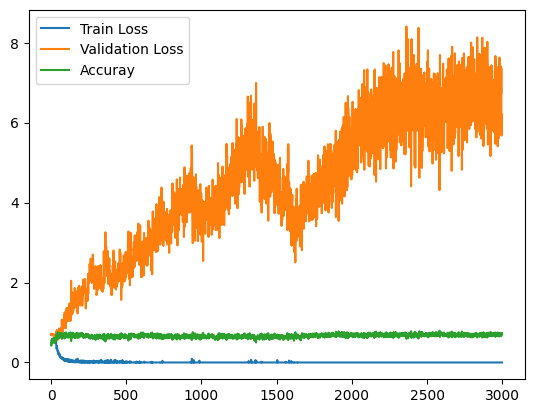

In [ ]:
plt.plot(trainer.totalLoss, label='Train Loss')
plt.plot(trainer.totalTestLoss, label='Validation Loss')
plt.plot(trainer.totalAccuray, label='Accuray')
plt.legend()

In [ ]:
max(trainer.totalAccuray)

0.7958333333333333

In [ ]:
trainer.totalAccuray[-1]

0.7125

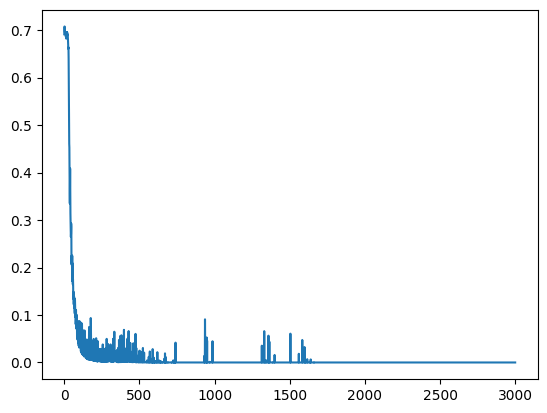

In [ ]:
plt.plot(trainer.totalLoss, label='Train Loss')

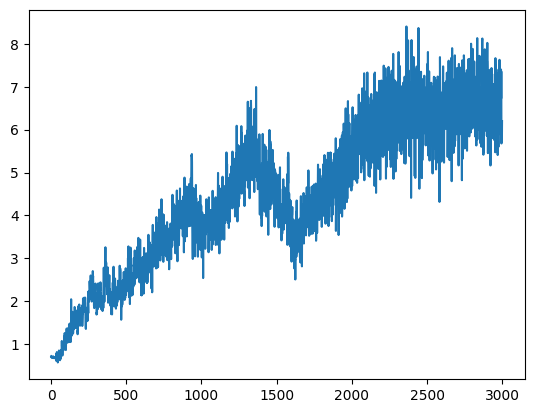

In [ ]:
plt.plot(trainer.totalTestLoss, label='Accuray')

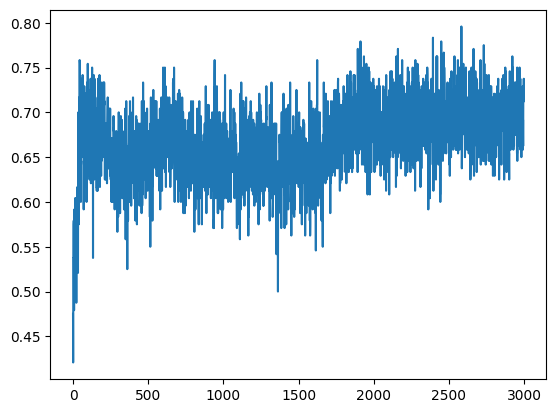

In [ ]:
plt.plot(trainer.totalAccuray, label='Accuray')